# CMU Advanced NLP 2022 : Introduction to NLP 

This notebook contains example codes from [anlp-codes](https://github.com/neubig/anlp-code/blob/main/01-rulebasedclassifier/rulebasedclassifier.ipynb). After downloading the original rule-based model, I next play around and try several simple modifications. First, I start with an analysis on data and visualize several properties to better understand it. Then in Methods section, I run the baseline model and my modifications to it. The notebook only contains simple rule-based model, not fancy deep learning models. 


## Section 1: Understanding the data 


The data is from [anlp-code/data](https://github.com/neubig/anlp-code/tree/main/data/sst-sentiment-text-threeclass).  Let's explore it.

In [52]:
import pandas as pd

In [53]:
# This function is from anlp-codes. 
def read_XY_data(filename):
    X_data = []
    Y_data = []
    with open(filename, 'r') as f:
        for line in f:
            label, text = line.strip().split(' ||| ')
            X_data.append(text)
            Y_data.append(int(label))
    return X_data, Y_data

For now, I only look the training and dev data. Test data is secret, we can't explore it. 

For better visualization and exploration, I will transform these two sets into pandas DataFrame.

In [54]:
X_train, Y_train = read_XY_data('data/sst-sentiment-text-threeclass/train.txt')
X_test, Y_test = read_XY_data('data/sst-sentiment-text-threeclass/dev.txt')

In [70]:
df = pd.DataFrame(list(zip(X_train + X_test, Y_train + Y_test)),
               columns =['Review', 'Label'])
df.head(5)

,Review,Label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer\/composer Bryan Adams contributes a sle...,1
3,You 'd think by now America would have had eno...,0
4,Yet the act is still charming here .,1


In [56]:
print("There are %d examples with %d columns"%(df.shape[0], df.shape[1]))

There are 9645 examples with 2 columns


Now, I try to answer several questions related to the training set. 

1. What is the distribution of the classes? 
2. What is the length (nbr of words) of the reviews by each classes? 
3. What is the most frequent adjectives in the reviews by the classes?
4. What is the most frequent names in the reviews by the classes?

In [57]:
import seaborn as sns 
import matplotlib.pyplot as plt

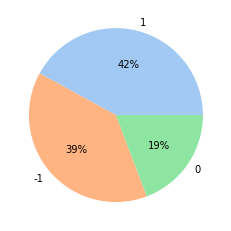

In [71]:
# 1. What is the distribution of the classes?
label_counts = df.Label.value_counts()
colors = sns.color_palette('pastel')[0:3]

#create pie chart
plt.pie(label_counts, labels = ["1","-1","0"], colors = colors, autopct='%.0f%%')
plt.show()

The distribution of the classes in the set is not homogeneous. The reviews from neutral class (0) is fewer than others(1,-1). 

In [72]:
# 2. What is the length of the reviews by each classes? 
# get the number of words in each review 
word_count = df.Review.str.split().str.len()
df['word_count'] = word_count
df.head(5)

,Review,Label,word_count
0,The Rock is destined to be the 21st Century 's...,1,36
1,The gorgeously elaborate continuation of `` Th...,1,37
2,Singer\/composer Bryan Adams contributes a sle...,1,39
3,You 'd think by now America would have had eno...,0,19
4,Yet the act is still charming here .,1,8


<BarContainer object of 3 artists>

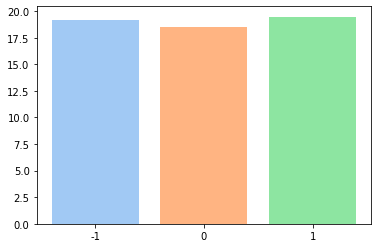

In [73]:
# Now get the average number of word count by classes 
average_word_nbr = df.groupby(['Label'])['word_count'].mean()
 
# creating the bar plot
plt.bar(["-1","0","1"], average_word_nbr, color=colors)

The average number of words in the reviews are very close for each class. 

For the next question, about finding the adjectives, I use nltk library to first tokenize the reviews than to tag them.

In [74]:
# 3. What is the most frequent adjectives in the reviews by the classes?
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mignon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [139]:
from nltk.tokenize import word_tokenize
text = word_tokenize("And now for something completely different is not coming")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('coming', 'VBG')]

In [115]:
df['tags'] = df.Review.apply(lambda x: nltk.pos_tag(word_tokenize(x.lower())))
df.head()

,Review,Label,word_count,tags
0,The Rock is destined to be the 21st Century 's...,1,36,"[(the, DT), (rock, NN), (is, VBZ), (destined, ..."
1,The gorgeously elaborate continuation of `` Th...,1,37,"[(the, DT), (gorgeously, RB), (elaborate, JJ),..."
2,Singer\/composer Bryan Adams contributes a sle...,1,39,"[(singer\/composer, NN), (bryan, NN), (adams, ..."
3,You 'd think by now America would have had eno...,0,19,"[(you, PRP), ('d, MD), (think, VB), (by, IN), ..."
4,Yet the act is still charming here .,1,8,"[(yet, RB), (the, DT), (act, NN), (is, VBZ), (..."


In [116]:
# transform dataframe into a dictionary 
df_dict = df.to_dict('index')
print("The keys are the index numbers ")
print("Each example contains: ", df_dict[0].keys())

The keys are the index numbers 
Each example contains:  dict_keys(['Review', 'Label', 'word_count', 'tags'])


In [117]:
from collections import Counter

In [127]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mignon/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [130]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

In [132]:
# collect tags of each class 
class_tags = {0:[],1:[],-1:[]}
for k,v in df_dict.items():
    class_tags[v["Label"]].append(v['tags'])
print("Number of tags in classes (0,1,-1) (%d,%d,%d)"%(len(class_tags[0]),len(class_tags[1]),len(class_tags[-1])))

Number of tags in classes (0,1,-1) (1853,4054,3738)


In [133]:
# flatten each list to get the counts of each word 
# filter to choose only adjactives 
# count the tag-word pairs in each class
adjectives = ["JJ","JJS","JJR"]
class_tags[0] = Counter([x for s in class_tags[0] for x in s if (x[1] in adjectives and not(x[0] in stop_words))])
class_tags[1] = Counter([x for s in class_tags[1] for x in s if x[1] in adjectives and not(x[0] in stop_words)])
class_tags[-1] = Counter([x for s in class_tags[-1] for x in s if x[1] in adjectives and  not(x[0] in stop_words)])

In [134]:
print("Most common adjectives in positive class : ")
print(class_tags[1].most_common(10))
print("Most common adjectives in negative class : ")
print(class_tags[-1].most_common(10))
print("Most common adjectives in neutral class : ")
print(class_tags[0].most_common(10))

Most common adjectives in positive class : 
[(('good', 'JJ'), 154), (('funny', 'JJ'), 119), (('best', 'JJS'), 117), (('little', 'JJ'), 90), (('new', 'JJ'), 80), (('great', 'JJ'), 75), (('many', 'JJ'), 59), (('big', 'JJ'), 58), (('human', 'JJ'), 57), (('real', 'JJ'), 57)]
Most common adjectives in negative class : 
[(('bad', 'JJ'), 152), (('much', 'JJ'), 93), (('good', 'JJ'), 91), (('little', 'JJ'), 89), (('new', 'JJ'), 60), (('many', 'JJ'), 57), (('funny', 'JJ'), 51), (('big', 'JJ'), 48), (('hard', 'JJ'), 46), (('better', 'JJR'), 43)]
Most common adjectives in neutral class : 
[(('good', 'JJ'), 58), (('much', 'JJ'), 39), (('little', 'JJ'), 38), (('funny', 'JJ'), 36), (('many', 'JJ'), 33), (('new', 'JJ'), 30), (('best', 'JJS'), 28), (('big', 'JJ'), 25), (('old', 'JJ'), 22), (('first', 'JJ'), 21)]


I don't see much differences just looking the adjective. The reason may be the negation. I can now check the verbs.

In [135]:
# collect tags of each class 
class_tags = {0:[],1:[],-1:[]}
for k,v in df_dict.items():
    class_tags[v["Label"]].append(v['tags'])
print("Number of tags in classes (0,1,-1) (%d,%d,%d)"%(len(class_tags[0]),len(class_tags[1]),len(class_tags[-1])))

Number of tags in classes (0,1,-1) (1853,4054,3738)


In [137]:
# flatten each list to get the counts of each word 
# filter to choose only verbs 
# count the tag-word pairs in each class
verbs = ["VB"]
class_tags[0] = Counter([x for s in class_tags[0] for x in s if x[1].startswith("VB") and not(x[0] in stop_words)])
class_tags[1] = Counter([x for s in class_tags[1] for x in s if x[1].startswith("VB") and not(x[0] in stop_words)])
class_tags[-1] = Counter([x for s in class_tags[-1] for x in s if x[1].startswith("VB") and not(x[0] in stop_words)])

In [138]:
print("Most common adjectives in positive class : ")
print(class_tags[1].most_common(20))
print("Most common adjectives in negative class : ")
print(class_tags[-1].most_common(20))
print("Most common adjectives in neutral class : ")
print(class_tags[0].most_common(20))

Most common adjectives in positive class : 
[(("'s", 'VBZ'), 562), (('makes', 'VBZ'), 105), (('make', 'VB'), 60), (("'re", 'VBP'), 50), (('see', 'VB'), 50), (('seen', 'VBN'), 44), (('gives', 'VBZ'), 43), (("'ve", 'VBP'), 42), (('make', 'VBP'), 40), (('takes', 'VBZ'), 39), (('keep', 'VB'), 39), (('made', 'VBN'), 38), (('works', 'VBZ'), 37), (('moving', 'VBG'), 37), (('take', 'VB'), 36), (('watch', 'VB'), 33), (('watching', 'VBG'), 33), (('seems', 'VBZ'), 33), (('get', 'VB'), 32), (('gets', 'VBZ'), 31)]
Most common adjectives in negative class : 
[(("'s", 'VBZ'), 553), (('make', 'VB'), 73), (('seems', 'VBZ'), 67), (('makes', 'VBZ'), 63), (("'re", 'VBP'), 57), (('comes', 'VBZ'), 50), (("'ve", 'VBP'), 46), (('watching', 'VBG'), 45), (('made', 'VBN'), 43), (('get', 'VB'), 42), (('see', 'VB'), 40), (('going', 'VBG'), 33), (('feel', 'VB'), 31), (('gets', 'VBZ'), 31), (('seem', 'VBP'), 31), (('trying', 'VBG'), 30), (('goes', 'VBZ'), 29), (('takes', 'VBZ'), 29), (('find', 'VB'), 29), (('go', 'V

# Build a Rule-based Sentiment Classifier

This is a notebook for [CMU CS11-711 Advanced NLP](http://phontron.com/class/anlp2021/), in which you can attempt to build a rule-based sentiment classifier. It will take in a text `X` and return a `label` of "1" if the sentiment of the text is positive, "-1" if the sentiment of the text is negative, and "0" if the sentiment of the text is neutral. You can test the accuracy of your classifier on the [Stanford Sentiment Treebank](http://nlp.stanford.edu/sentiment/index.html) by running the notebook all the way to end.

The only thing that you should change in this notebook is the following cell which contains two important elements. The first is `extract_features(X)`, which will extract a dictionary of (named) feature values from the text. You should create this by hand, and a simple example is shown for you. The second is `feature_weights`, a dictionary which will assign a weight to each extracted feature.

The final way the classifier decides whether to assign a positive, negative, or neutral label is by calculating the dot product `feature_weights * extract_features(X)`, and if the value is greater than zero, return 1, less than zero return -1, and if exactly zero return 0.

Let's have some fun trying to design a classifier 😁

In [36]:
def extract_features(X):
    features = {}
    X_split = X.split(' ')
    
    # Count the number of "good words" and "bad words" in the text
    good_words = ['love', 'good']
    bad_words = ['hate', 'bad']
    for x in good_words: 
        if x in X: 
            features['good_word_count'] = features.get('good_word_count', 0) + 1
    for x in bad_words: 
        if x in X: 
            features['bad_word_count'] = features.get('good_word_count', 0) + 1

    # The "bias" value is always one, to allow us to assign a "default" score to the text
    features['bias'] = 1
    
    return features

feature_weights = {'good_word_count': 1.0, 'bad_word_count': -1.0, 'bias': 0.5}

## Data Reading

Read in the data from the training and dev (or finally test) sets

In [37]:
def read_XY_data(filename):
    X_data = []
    Y_data = []
    with open(filename, 'r') as f:
        for line in f:
            label, text = line.strip().split(' ||| ')
            X_data.append(text)
            Y_data.append(int(label))
    return X_data, Y_data

In [38]:
X_train, Y_train = read_XY_data('data/sst-sentiment-text-threeclass/train.txt')
X_test, Y_test = read_XY_data('data/sst-sentiment-text-threeclass/dev.txt')

In [39]:
print(X_train[0])
print(Y_train[0])

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
1


## Run the Classifier and Calculate Accuracy

Run the classifier over the training and dev (test) sets and calculate accuracy

In [40]:
def run_classifier(X):
    score = 0
    for feat_name, feat_value in extract_features(X).items():
        score = score + feat_value * feature_weights.get(feat_name, 0)
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0

In [41]:
def calculate_accuracy(X_data, Y_data):
    total_number = 0
    correct_number = 0
    for X, Y in zip(X_data, Y_data):
        Y_pred = run_classifier(X)
        total_number += 1
        if Y == Y_pred:
            correct_number += 1
    return correct_number / float(total_number)

In [42]:
train_accuracy = calculate_accuracy(X_train, Y_train)
test_accuracy = calculate_accuracy(X_test, Y_test)
print(f'Train accuracy: {train_accuracy}')
print(f'Dev/test accuracy: {test_accuracy}')

Train accuracy: 0.43551029962546817
Dev/test accuracy: 0.4196185286103542


## Error Analysis

An important part of improving any system is figuring out where it goes wrong. The following two functions allow you to randomly observe some mistaken examples, which may help you improve the classifier. Feel free to write more sophisticated methods for error analysis as well.

In [43]:
import random
def find_errors(X_data, Y_data):
    error_ids = []
    Y_preds = []
    for i, (X, Y) in enumerate(zip(X_data, Y_data)):
        Y_preds.append(run_classifier(X))
        if Y != Y_preds[-1]:
            error_ids.append(i)
    for _ in range(5):
        my_id = random.choice(error_ids)
        X, Y, Y_pred = X_data[my_id], Y_data[my_id], Y_preds[my_id]
        print(f'{X}\ntrue label: {Y}\npredicted label: {Y_pred}\n')

In [44]:
find_errors(X_train, Y_train)

Every visual joke is milked , every set-up obvious and lengthy , every punchline predictable .
true label: -1
predicted label: 1

But here 's a movie about it anyway .
true label: -1
predicted label: 1

Dark and disturbing , yet compelling to watch .
true label: 0
predicted label: 1

Lucky Break is perfectly inoffensive and harmless , but it 's also drab and inert .
true label: 0
predicted label: 1

Master of Disguise runs for only 71 minutes and feels like three hours .
true label: -1
predicted label: 1



# How to improve the results? 

* I can get a dictionary from training data to assign as good and bad words. 
* Using n-grams to score the negative, positive words 
* Using stemming 



I have already examined the data and the vocabulary. I can first expand the bad and good vocabulary in the feature extraction.

In [45]:
def extract_features(X):
    features = {}
    X_split = X.split(' ')
    
    # Count the number of "good words" and "bad words" in the text
    good_words = ['love','entertaining', 'real', 'new', 'great', 'best', 'funny', 'good']
    bad_words = ['dull', 'worst', 'hard', 'bad']
    for x in good_words: 
        if x in X: 
            features['good_word_count'] = features.get('good_word_count', 0) + 1
    for x in bad_words: 
        if x in X: 
            features['bad_word_count'] = features.get('good_word_count', 0) + 1

    # The "bias" value is always one, to allow us to assign a "default" score to the text
    features['bias'] = 1
    
    return features

feature_weights = {'good_word_count': 1.0, 'bad_word_count': -1.0, 'bias': 0.5}

In [46]:
train_accuracy = calculate_accuracy(X_train, Y_train)
test_accuracy = calculate_accuracy(X_test, Y_test)
print(f'Train accuracy: {train_accuracy}')
print(f'Dev/test accuracy: {test_accuracy}')

Train accuracy: 0.44592696629213485
Dev/test accuracy: 0.4305177111716621
